In [1]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf

flags.DEFINE_string('classes', './data/plate.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints_sgd_0.01/yolov3_train_15.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/Plate_dataset/AC/test/jpeg/1.jpg', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 1, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import matplotlib.pyplot as plt
import os
import tqdm

In [2]:
def bzh(x, y):
    return tf.image.per_image_standardization(x), y

In [3]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes, iou_threshold=0.01, score_threshold=0.01)

#yolo.load_weights("bzh_ckpts/yolov3_train_055.tf").expect_partial()
yolo.load_weights("last_ckpts/yolov3_train_056.tf").expect_partial()
logging.info('weights loaded')

I0507 09:38:51.702312 139944410670912 <ipython-input-3-7f3c33d353a4>:8] weights loaded


In [4]:
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

I0507 09:38:56.397982 139944410670912 <ipython-input-4-f85126b2db62>:2] classes loaded


In [48]:
yolo = YoloV3Tiny(classes=1)
yolo.load_weights('tiny/yolov3_tiny_train_200.tf').expect_partial()

In [110]:
img_raw = tf.image.decode_image(
        open('./data/Plate_dataset/AC/test/jpeg/16.jpg', 'rb').read(), channels=3)

In [111]:
#img = tf.expand_dims(tf.image.per_image_standardization(img_raw[16:-24]), 0)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

In [112]:
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

I0507 10:41:04.567397 139944410670912 <ipython-input-112-9a4b5cad84aa>:4] time: 0.09637165069580078


In [113]:
print(np.max(scores), nums[0])

0.49999142 tf.Tensor(1, shape=(), dtype=int32)


In [114]:
logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                       np.array(scores[0][i]),
                                       np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

I0507 10:41:05.643237 139944410670912 <ipython-input-114-c41a847f3a8d>:1] detections:
I0507 10:41:05.651884 139944410670912 <ipython-input-114-c41a847f3a8d>:3] 	plate, 0.49999141693115234, [0.26319182 0.6051057  0.4762386  0.7429928 ]


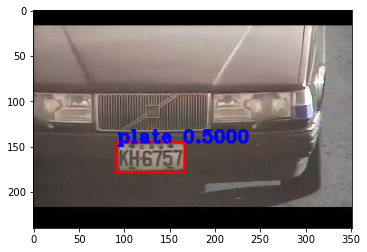

In [115]:
plt.imshow(img)

In [116]:
cv2.imwrite(FLAGS.output, img)
logging.info('output saved to: {}'.format(FLAGS.output))

I0507 10:41:07.151360 139944410670912 <ipython-input-116-7704f195954c>:2] output saved to: ./output.jpg


In [107]:
x1,y1,x2,y2 = boxes[0][0]
print(boxes[0][0])

tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


In [108]:
boxes.backing_device

'/job:localhost/replica:0/task:0/device:CPU:0'

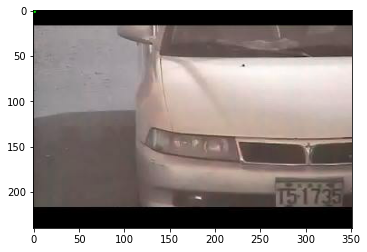

In [109]:
delta = 0
# leave 0 pixel bounder
H,W,_=img.shape
std = np.array([[delta,delta],[W-1-delta,delta],[W-1-delta,H-1-delta],[delta,H-1-delta]],dtype=np.float32)
pos = np.array([[x1*W,y1*H], [x2*W,y1*H], [x2*W,y2*H], [x1*W,y2*H]],dtype=np.float32)
siz = (int(x2-x1), int(y2-y1))
warped = cv2.getPerspectiveTransform(src=pos,dst=std)
tmp=img.copy()
for i in pos:
    x=int(i[0])
    y=int(i[1])
    tmp=cv2.circle(tmp,(x,y),3,(0, 255, 0) ,-1)
plt.imshow(tmp)

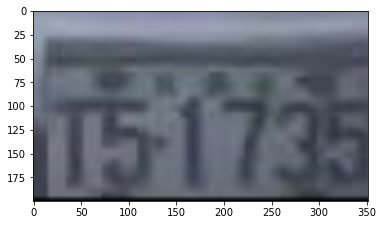

In [82]:
result = cv2.warpPerspective(img_raw[16:-24].numpy(), warped, siz)
plt.imshow(result)

In [85]:
lst = os.listdir('./data/Plate_dataset/AC/test/jpeg/')
maxes = {}
tot = 0
for filename in tqdm.tqdm(lst):
    if filename.endswith('.jpg'):
        img_raw = tf.image.decode_image(open(os.path.join('./data/Plate_dataset/AC/test/jpeg/', filename), 'rb').read(), channels=3)
        img = tf.expand_dims(img_raw, 0)
        img = transform_images(img, FLAGS.size)
        boxes, scores, classes, nums = yolo(img)
        maxes[filename] = np.max(scores)
        if maxes[filename] < 0.01:
            tot += 1

100%|██████████| 101/101 [00:08<00:00, 12.42it/s]


In [86]:
print(tot, maxes)

2 {'1.jpg': 0.49966037, '10.jpg': 0.4999445, '100.jpg': 0.49980214, '11.jpg': 0.4997199, '12.jpg': 0.49998307, '13.jpg': 0.49996167, '14.jpg': 0.49979648, '15.jpg': 0.0, '16.jpg': 0.49999142, '17.jpg': 0.4999646, '18.jpg': 0.49994498, '19.jpg': 0.49996775, '2.jpg': 0.4978825, '20.jpg': 0.47828314, '21.jpg': 0.4998952, '22.jpg': 0.49937114, '23.jpg': 0.4999715, '24.jpg': 0.49994946, '25.jpg': 0.49857476, '26.jpg': 0.4995927, '27.jpg': 0.4997199, '28.jpg': 0.49984896, '29.jpg': 0.49998415, '3.jpg': 0.4999686, '30.jpg': 0.49999726, '31.jpg': 0.49262005, '32.jpg': 0.48001572, '33.jpg': 0.49999154, '34.jpg': 0.49992996, '35.jpg': 0.49999923, '36.jpg': 0.4998937, '37.jpg': 0.49998635, '38.jpg': 0.4983444, '39.jpg': 0.49814463, '4.jpg': 0.4999894, '40.jpg': 0.49978086, '41.jpg': 0.49999523, '42.jpg': 0.49980944, '43.jpg': 0.49993974, '44.jpg': 0.4999985, '45.jpg': 0.4999861, '46.jpg': 0.48663357, '47.jpg': 0.49990562, '48.jpg': 0.49994063, '49.jpg': 0.49987373, '5.jpg': 0.49991235, '50.jpg': 